In [26]:
%pip install -Uq diffusers ftfy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00


In [27]:
from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

model_id1 = "dreamlike-art/dreamlike-diffusion-1.0"
model_id2 = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionPipeline.from_pretrained(model_id1, torch_dtype=torch.float16, use_safetensors=True)
pipe = pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

generator = torch.Generator(device=device).manual_seed(1)



  0%|          | 0/50 [00:00<?, ?it/s]

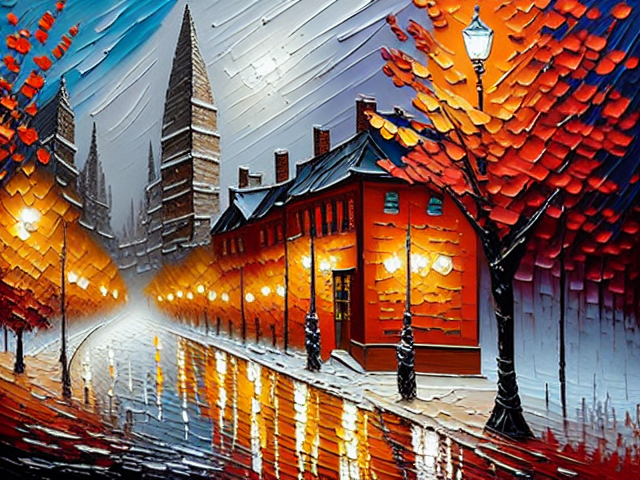

In [24]:
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=10,          # How strongly to follow the prompt
    num_inference_steps=50,    # How many steps to take
    generator=generator     # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

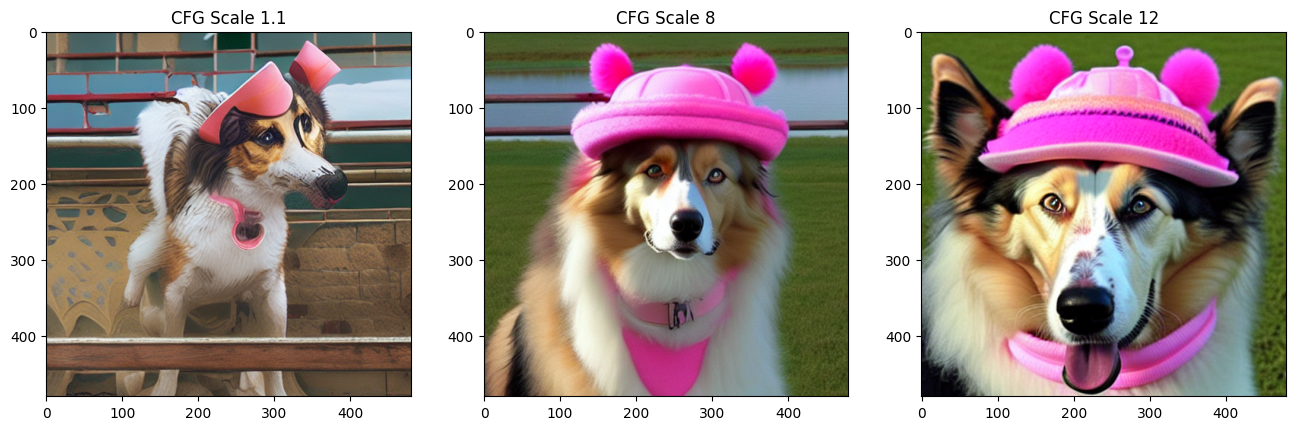

In [25]:
#@markdown comparing guidance scales:
"""  This is a setting that controls how strongly the model follows the prompt. A higher scale makes the model stick more closely to the prompt, while a lower scale allows more creativity and randomness.  """
cfg_scales = [1.1, 8, 12] #@param

""" The code uses the prompt "A collie with a pink hat" to generate images of a dog with a pink hat.  """
prompt = "A collie with a pink hat" #@param

""" s: The code tries three different guidance scales: 1.1, 8, and 12, and generates an image for each one   """
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

In [28]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [30]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)


# Cast images to float16 to match the model's data type
images = images.type(torch.float16)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])
